# Libraries

In [1]:
!pip install imutils
 
import os
import pandas as pd
import numpy as np
import cv2

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import seaborn as sns

import skimage
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.base import BaseEstimator, TransformerMixin

import itertools
import random
import imutils

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Load the dataset

In [2]:
!rm -r anomalydetection # Reload github repository
#!rm -r products


if not os.path.isdir('./anomalydetection'):
  !git clone https://github.com/lindaludovisi/anomalydetection.git
  #!mv 'anomalydetection' 'products' 
os.chdir('anomalydetection') # Change working directory


rm: cannot remove 'anomalydetection': No such file or directory
Cloning into 'anomalydetection'...
remote: Enumerating objects: 602, done.
remote: Total 602 (delta 0), reused 0 (delta 0), pack-reused 602
Receiving objects: 100% (602/602), 19.47 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (88/88), done.


#Preprocessing

* The source folder is the input parameter containing the images for different classes.
* Read the image file from the folder and convert it to the right color format.
* Resize the image based on the input dimension required for the model
* Convert the image to a Numpy array with float32 as the datatype
* Normalize the image array to have values scaled down between 0 and 1 from 0 to 255 for a similar data distribution, which helps with faster convergence.

In [3]:
# Resize images using the following measures
IMG_WIDTH   = 300
IMG_HEIGHT  = 395

IMG_FOLDER = r'dataset_products'
#print(len(os.listdir(img_folder)))  # This should be 2

def create_dataset(img_folder):   
    img_data_array  = []
    class_name      = []   
    
    for dir1 in ['compliant', 'defected']:   # For each category
        for frame in os.listdir(os.path.join(img_folder, dir1)): # For each file      
            # Load image and convert to RGB
            image_path = os.path.join(img_folder, dir1, frame)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            #image = cv2.imread(image_path)

            # Resize the image. Stretch the image using cv2.INTER_AREA
            dim = (IMG_WIDTH, image.shape[0])
            image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            image = np.array(image, dtype='float32')
            
            y = image.shape[0]
            diff  = y - IMG_HEIGHT
            crop1 = np.array(image[0:(int((1/3)*y)), :], dtype='float32')
            crop2 = np.array(image[int((1/3)*y)+diff:, :], dtype='float32')
            image = np.concatenate((crop1, crop2))
            image = np.array(image, dtype='float32')

            # Normalize the image (0,1) 
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)
img_data = np.array(img_data, np.float32)
print(f"Images have shape {img_data.shape}")

# Create a dictionary for the labels
target_dict = { k : v for v, k in enumerate(np.unique(class_name))}
print(target_dict)

# Convert category names to label values
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]
target_val = np.array(target_val)
print(f"Target array has shape {target_val.shape}")

Images have shape (406, 395, 300, 3)
{'compliant': 0, 'defected': 1}
Target array has shape (406,)


# Using HOG features

A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful information and throwing away extraneous information.

* the feature vector is not useful for the purpose of viewing the image. But, it is very useful for tasks like image recognition and object detection. The feature vector produced by these algorithms when fed into an image classification algorithms like Support Vector Machine (SVM) produce good results.

In the HOG feature descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.

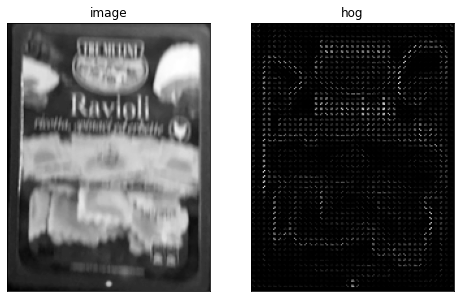

number of pixels:  32136
number of hog features:  68400


In [4]:
# Just an example of HOG features

prod = imread('defected_artificial/transparent/col1_down_12.jpg', as_gray=True)
 
# scale down the image 
prod = rescale(prod, 1/2, mode='reflect')
# calculate the hog and return a visual representation.
prod_hog, prod_hog_img = hog(
    prod, pixels_per_cell=(4,4), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(prod, cmap='gray')
ax[0].set_title('image')
ax[1].imshow(prod_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

print('number of pixels: ', prod.shape[0] * prod.shape[1])
print('number of hog features: ', prod_hog.shape[0])

In [5]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each image
    """ 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
       
        X = np.array([rescale(img, 1/2, mode='reflect') for img in X])
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys')
scalify = StandardScaler()


X = img_data.copy()
y = target_val.copy()
# Construct the training and test splits 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


# Data Augmentation
def noisy(noise_typ,image):
  # Rotate the image (cropped version / use rotate_bound instead)
  angles = np.arange(0, 360, 15)
  rotated = imutils.rotate(image, np.random.choice(angles))
  image = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)

  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.01
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out

# Perform data Augmentation on training set
'''
img_augmented = []
for img in X_train:  
  if np.random.choice([0,1]) == 1:
    # Perform data augmentation
    img = noisy('s&p', img) 
  img_augmented.append(img)

img_augmented = np.asarray(img_augmented)
X_train = img_augmented.copy()
'''


# Call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

# Call transform on test set
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

X_train = X_train_prepared.copy()
X_test = X_test_prepared.copy()


(304, 4212)


#Building the model


In [7]:
IMG_HEIGHT  = 395
IMG_WIDTH   = 300


def searchHyper(pipeline, grid, X_train, y_train):
  gsCV = GridSearchCV(pipeline, param_grid = grid, scoring='f1_weighted', 
                      verbose = 0, cv=5, n_jobs=-1)
  gsCV.fit(X_train, y_train)

  print()
  print(f"Best parameters set found on development set: {gsCV.best_params_}")

  return gsCV 


def applyModel(gsCV, print_img=0):  
  print("Detailed classification report:")
  y_pred = gsCV.best_estimator_.predict(X_test)
  print(classification_report(y_test, y_pred))
  print()

  #F1 score
  f1 = f1_score(y_test, y_pred, average='weighted')
  print(f"F1-score is: {f1}")
  # Plot confusion matrix
  plt.figure(figsize=(10,7))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.1f', cmap=sns.color_palette("Blues", 25))
  plt.show()

  # Print misclassified samples
  if print_img == 1:
    y_true = np.asarray(y_test)
    X_true = np.asarray(X_test)
    not_correct = [test for pred, true, test in zip(y_pred, y_true, X_true) if pred!=true]
    for img in not_correct:
      #img *= 255
      img = img.reshape(IMG_HEIGHT, IMG_WIDTH, 3)
      
      plt.figure()
      plt.imshow(img) 
      plt.show()
  
  return np.asarray(y_pred)


#KNN

In [8]:
#@title #####> Click here to show code


#make pipeline for KNN
pipeline_knn = imbPipeline([
                     ('classifier', KNN())
                     ]) 

# Set the parameters 
grid_knn = {'classifier__n_neighbors': [3, 4, 5, 7 ]}

## *KNN on standardized + HOG*


Best parameters set found on development set: {'classifier__n_neighbors': 7}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        55
           1       0.81      0.64      0.71        47

    accuracy                           0.76       102
   macro avg       0.77      0.76      0.76       102
weighted avg       0.77      0.76      0.76       102


F1-score is: 0.7605042016806722


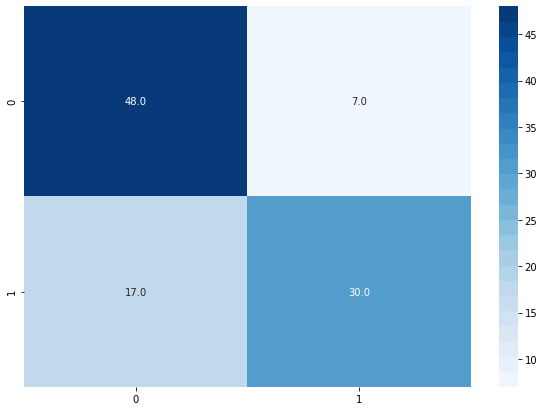

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1])

In [9]:
knn_model = searchHyper(pipeline_knn, grid_knn, X_train, y_train)
applyModel(knn_model)

# Decision Tree

In [10]:
#@title #####> Click here to show code


#make pipeline for DT
pipeline_dt = imbPipeline([
                     ('classifier', DecisionTreeClassifier())
                     ]) 

grid_dt = {'classifier__criterion': ["gini", "entropy"],
            'classifier__max_depth': [5, 10, 13, 14, 15, 20]}

## *Decision Tree on standardized + HOG*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        55
           1       0.75      0.70      0.73        47

    accuracy                           0.75       102
   macro avg       0.75      0.75      0.75       102
weighted avg       0.75      0.75      0.75       102


F1-score is: 0.754115397009723


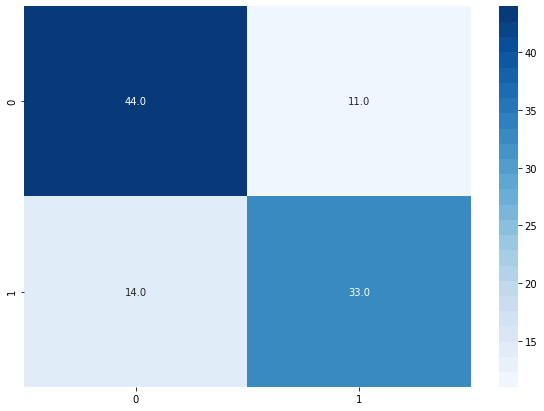

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

In [11]:
dt_model = searchHyper(pipeline_dt, grid_dt, X_train, y_train)
applyModel(dt_model)

# Random Forest

In [12]:
#@title #####> Click here to show code

#make pipeline for RF
pipeline_rf = imbPipeline([
                     ('classifier', RandomForestClassifier())
                     ]) 

grid_rf = {'classifier__criterion': ["gini", "entropy"],
            'classifier__max_depth': [5, 10, 15],
           'classifier__n_estimators': [2, 3, 4, 5]}

## *Random Forest on standardized dataset + HOG*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__n_estimators': 3}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.69        55
           1       0.63      0.70      0.67        47

    accuracy                           0.68       102
   macro avg       0.68      0.68      0.68       102
weighted avg       0.68      0.68      0.68       102


F1-score is: 0.676937441643324


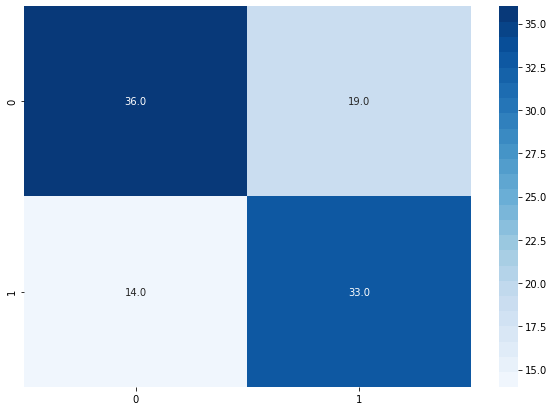

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [13]:
rf_model = searchHyper(pipeline_rf, grid_rf, X_train, y_train)
applyModel(rf_model)

# Linear SVC

In [14]:
#@title #####> Click here to show code

#make pipeline for SVC
pipeline_svc = imbPipeline([
                     ('classifier', svm.LinearSVC())
                     ]) 

# Set the parameters 
grid_svc = {'classifier__C': [ 0.1, 1, 10, 100]}


#make pipeline for SVC
pipeline_rbf = imbPipeline([
                     ('classifier', svm.SVC(kernel='rbf'))
                     ]) 

# Set the parameters 
grid_rbf = {'classifier__C': [ 0.1, 1, 10, 100],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

## *Linear SVC on standardized + HOG*


Best parameters set found on development set: {'classifier__C': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        55
           1       0.80      0.83      0.81        47

    accuracy                           0.82       102
   macro avg       0.82      0.82      0.82       102
weighted avg       0.82      0.82      0.82       102


F1-score is: 0.823733660130719


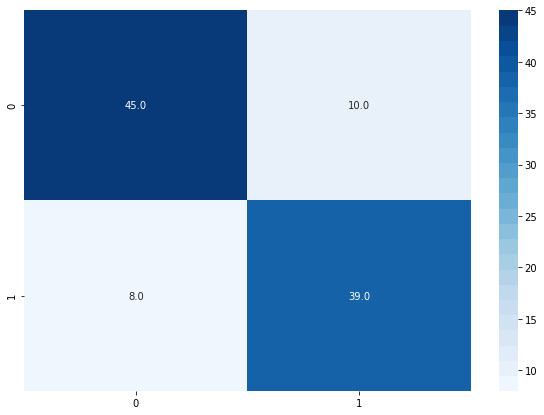

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [15]:
svc_model = searchHyper(pipeline_svc, grid_svc, X_train, y_train)
applyModel(svc_model)

## *SVC kernel rbf on standardized + HOG*


Best parameters set found on development set: {'classifier__C': 10, 'classifier__gamma': 0.001}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        55
           1       0.87      0.57      0.69        47

    accuracy                           0.76       102
   macro avg       0.79      0.75      0.75       102
weighted avg       0.79      0.76      0.76       102


F1-score is: 0.7555124613948145


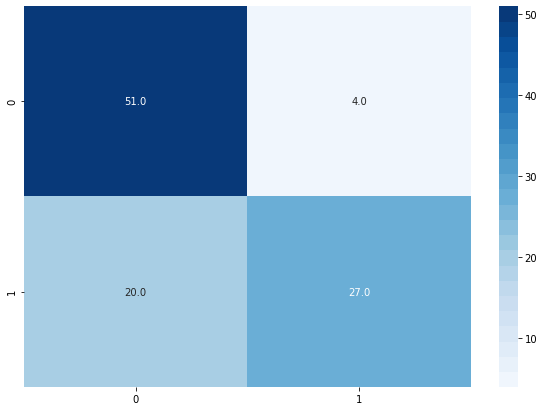

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [16]:
gsCV = searchHyper(pipeline_rbf, grid_rbf, X_train, y_train)
applyModel(gsCV)

# ANOVA

In [22]:
#----------------------------------------------------------
# FACTORS
# Defining the list of the factors for artificial DoE design
#----------------------------------------------------------

SIZE     = ["12","11","9","8"]          # in pixels
COLOR    = ["col1","col2","col3"]       # pasta, label, ground_white
POSITION = ["down","up","left","right"]

NUM_RANDOM_ITER = 47
NAMES    = ["Colour", "Noise Position", "Noise Size"]
PATH = "randomized_doe_black.xlsx"

IMG_FOLDER = 'defected_artificial/black/'
#IMG_FOLDER = 'defected_artificial/transparent/'
IMG_WIDTH   = 300
IMG_HEIGHT  = 395

#----------------------------------------------------------
# COMBINATIONS
# Computes experiments list as combinations of factor
# elements
#----------------------------------------------------------

elements = [COLOR, POSITION, SIZE]
doe_design = list(itertools.product(*elements))

# RANDOMIZE!!!! It is very important in DoE approach to avoid
# environmental noises
for it in range(1,NUM_RANDOM_ITER+1):
    random.shuffle(doe_design)


# Preprocessing
img_array  = []
for el in doe_design:
  img_name = el[0] + '_' + el[1] + '_' + el[2] + '.jpg'
  image_path = os.path.join(IMG_FOLDER, img_name)
  image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

  # Resize the image. Stretch the image using cv2.INTER_AREA
  dim = (IMG_WIDTH, image.shape[0])
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  image = np.array(image, dtype='float32')
  
  y = image.shape[0]
  diff  = y - IMG_HEIGHT
  crop1 = np.array(image[0:(int((1/3)*y)), :], dtype='float32')
  crop2 = np.array(image[int((1/3)*y)+diff:, :], dtype='float32')
  image = np.concatenate((crop1, crop2))
  image = np.array(image, dtype='float32')

  image /= 255
  #image = image.flatten()
  img_array.append(image)

img_array = np.array(img_array)
print(img_array.shape)
print(len(img_array))
labels_defected = np.array([1]*len(img_array))
print(labels_defected)


(48, 395, 300, 3)
48
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [23]:

# Call transform on test set
X_test_gray = grayify.transform(img_array)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

X_test = X_test_prepared.copy()
y_test = labels_defected.copy()




Detailed classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      48.0

    accuracy                           0.00      48.0
   macro avg       0.00      0.00      0.00      48.0
weighted avg       0.00      0.00      0.00      48.0


F1-score is: 0.0


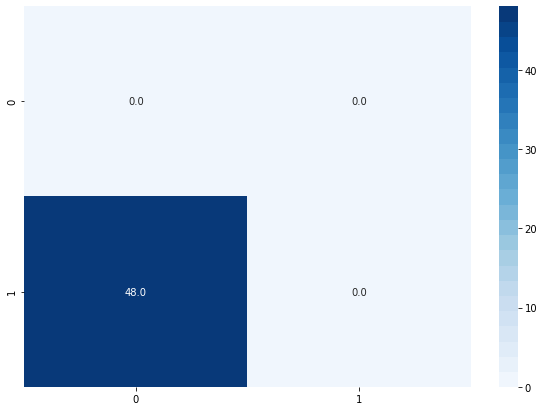

Detailed classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      48.0

    accuracy                           0.00      48.0
   macro avg       0.00      0.00      0.00      48.0
weighted avg       0.00      0.00      0.00      48.0


F1-score is: 0.0


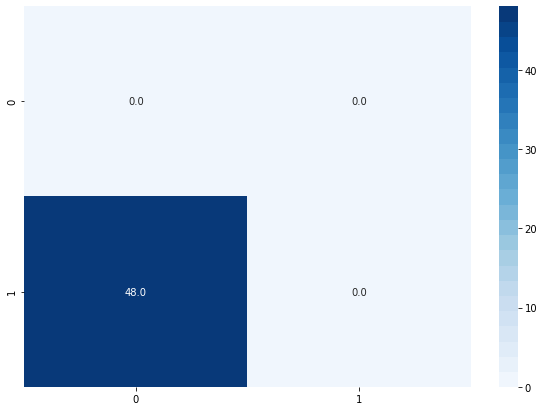

Detailed classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


F1-score is: 1.0


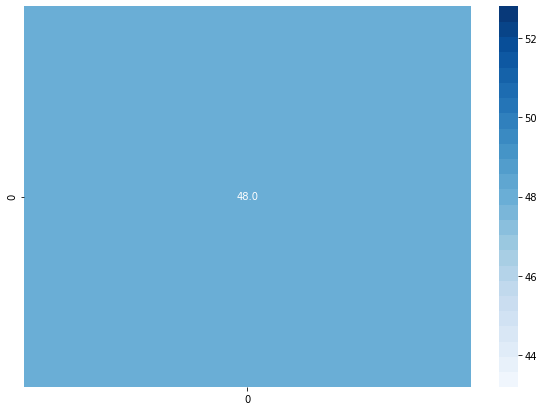

Detailed classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      48.0

    accuracy                           0.00      48.0
   macro avg       0.00      0.00      0.00      48.0
weighted avg       0.00      0.00      0.00      48.0


F1-score is: 0.0


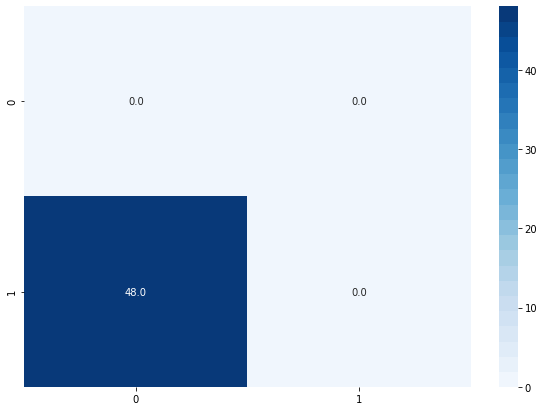

In [24]:
knn_res = applyModel(knn_model)
dt_res = applyModel(dt_model)
rf_res = applyModel(rf_model)
svc_res = applyModel(svc_model)

In [25]:
print(knn_res, dt_res, rf_res, svc_res)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [26]:


#Save on Dataframe object...
data_frame = pd.DataFrame(doe_design, columns=NAMES)
data_frame['KNN'] = knn_res
data_frame['Decision Tree'] = dt_res
data_frame['Rand Forest'] = rf_res
data_frame['SVC'] = svc_res
data_frame.to_excel("randomized_doe_transparent.xlsx")